# LSTM vs GRU: Microsoft Stock Prediction 


TensorFlow: 2.20.0

   Original shape: (1509, 5)
   Date range: 2018-01-02 00:00:00 to 2023-12-29 00:00:00

   Missing values before: 0
   Missing values after: 0
   Created 12 technical features
   Final data shape: (1489, 20)

   Train: 1189 samples
   Test: 210 samples

   Original shape: (1509, 5)
   Date range: 2018-01-02 00:00:00 to 2023-12-29 00:00:00

   Missing values before: 0
   Missing values after: 0
   Created 12 technical features
   Final data shape: (1489, 20)

   Train: 1189 samples
   Test: 210 samples

   LSTM parameters: 437,951
   LSTM parameters: 437,951
   GRU parameters: 331,551

   GRU parameters: 331,551

    Trained 16 epochs
    Trained 16 epochs
    Trained 25 epochs



 ACCURACY CALCULATION


 LSTM MODEL - DETAILED CALCULATION

1. Absolute Errors:
   Mean error: $20.08
   RMSE: $22.76

2. Percentage Error (MAPE):
   Sample calculation for first prediction:
   Actual: $246.32
   Predicted: $247.52
   Error: $1.20
   Percentage Error: 0.49%
   
   Average o

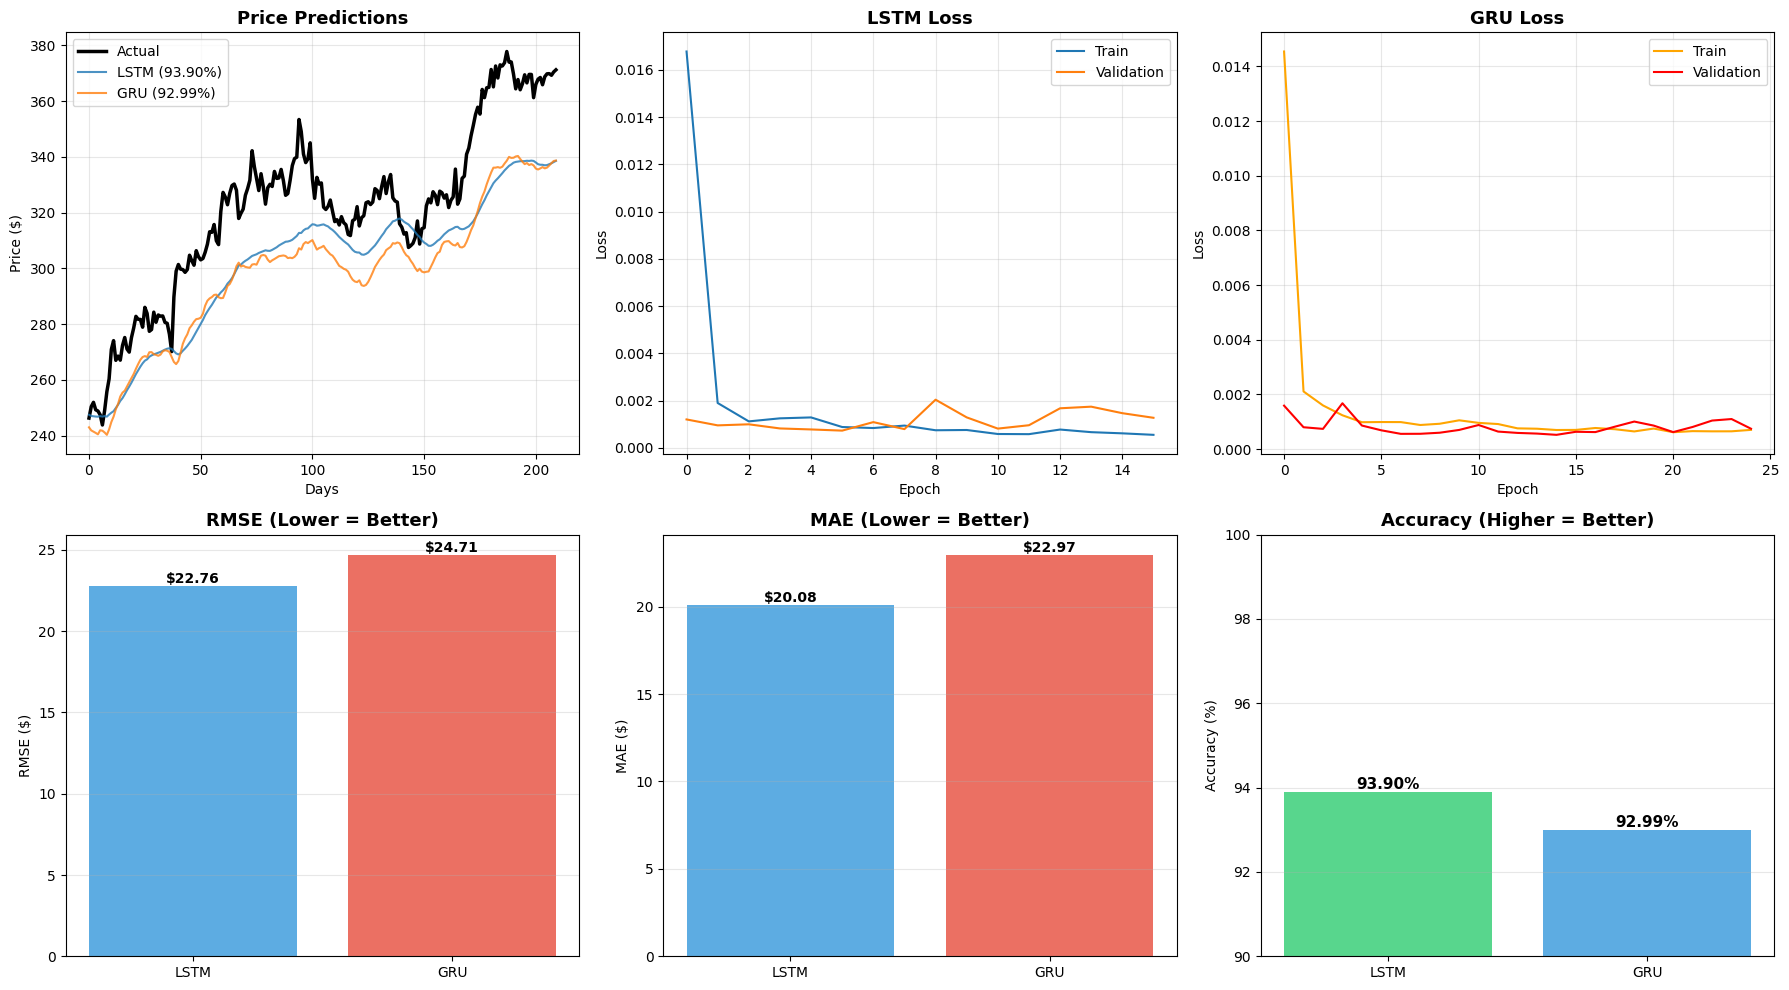

In [1]:
# Complete LSTM vs GRU Stock Prediction - Using Microsoft_Stock.csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}\n")

# STEP 1: Load Data from CSV
msft = pd.read_csv('Microsoft_Stock.csv')
msft['Date'] = pd.to_datetime(msft['Date'])
msft = msft.sort_values('Date')
msft.set_index('Date', inplace=True)
print(f"   Original shape: {msft.shape}")
print(f"   Date range: {msft.index[0]} to {msft.index[-1]}")
print(f"   Columns: {list(msft.columns)}\n")

# STEP 2: Handle Missing Values
missing_before = msft.isnull().sum().sum()
print(f"   Missing values before: {missing_before}")
msft = msft.fillna(method='ffill').fillna(method='bfill')
missing_after = msft.isnull().sum().sum()
print(f"   Missing values after: {missing_after}\n")

# STEP 3: Feature Engineering
df = msft.copy()

# Price features
df['Returns'] = df['Close'].pct_change()
df['High_Low'] = (df['High'] - df['Low']) / df['Close']
df['Close_Open'] = (df['Close'] - df['Open']) / df['Open']

# Moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()
df['MA_Ratio'] = df['MA7'] / df['MA21']

# Volatility
df['Volatility'] = df['Returns'].rolling(window=7).std()

# RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2

# Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Std'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']

# Volume
df['Volume_Change'] = df['Volume'].pct_change()

# Drop NaN
df = df.dropna()
print(f"   Final data shape: {df.shape}\n")

# STEP 4: Prepare Data
feature_columns = ['Close', 'Volume', 'Returns', 'High_Low', 'Close_Open',
                   'MA7', 'MA21', 'MA_Ratio', 'Volatility', 'RSI', 'MACD', 'BB_Width']
data = df[feature_columns].values
target = df['Close'].values.reshape(-1, 1)

# Normalize
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_X.fit_transform(data)
scaled_target = scaler_y.fit_transform(target)

# Create sequences
def create_sequences(data, target, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(target[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, scaled_target, 60)

# Split
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"   Sequence length: 60 days")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples\n")

# STEP 5: Build Models
lstm_model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(50, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='huber', metrics=['mae'])
print(f"   LSTM parameters: {lstm_model.count_params():,}")

gru_model = Sequential([
    Bidirectional(GRU(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(50, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='huber', metrics=['mae'])
print(f"   GRU parameters: {gru_model.count_params():,}\n")

# STEP 6: Train Models
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

lstm_history = lstm_model.fit(X_train, y_train, batch_size=32, epochs=50,
                               validation_split=0.15, callbacks=[early_stop, reduce_lr], verbose=0)
print(f"   LSTM trained for {len(lstm_history.history['loss'])} epochs")

gru_history = gru_model.fit(X_train, y_train, batch_size=32, epochs=50,
                             validation_split=0.15, callbacks=[early_stop, reduce_lr], verbose=0)
print(f"   GRU trained for {len(gru_history.history['loss'])} epochs\n")

# STEP 7: Predictions & Metrics
lstm_pred = scaler_y.inverse_transform(lstm_model.predict(X_test, verbose=0))
gru_pred = scaler_y.inverse_transform(gru_model.predict(X_test, verbose=0))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_r2 = r2_score(y_test_actual, lstm_pred)
lstm_mape = np.mean(np.abs((y_test_actual - lstm_pred) / y_test_actual)) * 100
lstm_accuracy = 100 - lstm_mape

gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_pred))
gru_mae = mean_absolute_error(y_test_actual, gru_pred)
gru_r2 = r2_score(y_test_actual, gru_pred)
gru_mape = np.mean(np.abs((y_test_actual - gru_pred) / y_test_actual)) * 100
gru_accuracy = 100 - gru_mape

# STEP 8: Display Results
print("\n")
print("ACCURACY CALCULATION")

# LSTM Results
print("\nLSTM MODEL:")
print(f"   1. Mean Absolute Error (MAE): ${lstm_mae:.2f}")
print(f"   2. Root Mean Square Error (RMSE): ${lstm_rmse:.2f}")
print(f"   3. Mean Absolute Percentage Error (MAPE): {lstm_mape:.2f}%")
print(f"   4. ACCURACY = 100% - MAPE = 100% - {lstm_mape:.2f}%")
print(f"      ACCURACY = {lstm_accuracy:.2f}%")
print(f"   5. R² Score: {lstm_r2:.4f}")

# GRU Results
print("\nGRU MODEL:")
print(f"   1. Mean Absolute Error (MAE): ${gru_mae:.2f}")
print(f"   2. Root Mean Square Error (RMSE): ${gru_rmse:.2f}")
print(f"   3. Mean Absolute Percentage Error (MAPE): {gru_mape:.2f}%")
print(f"   4. ACCURACY = 100% - MAPE = 100% - {gru_mape:.2f}%")
print(f"      ACCURACY = {gru_accuracy:.2f}%")
print(f"   5. R² Score: {gru_r2:.4f}")

# Winner
print("\n")
print("WINNER")
if lstm_accuracy > gru_accuracy:
    print(f"   LSTM: {lstm_accuracy:.2f}% (WINNER)")
    print(f"   GRU: {gru_accuracy:.2f}%")
    print(f"   LSTM wins by {lstm_accuracy - gru_accuracy:.2f}%")
else:
    print(f"   GRU: {gru_accuracy:.2f}% (WINNER)")
    print(f"   LSTM: {lstm_accuracy:.2f}%")
    print(f"   GRU wins by {gru_accuracy - lstm_accuracy:.2f}%")

print("\nAccuracy Rating:")
if min(lstm_accuracy, gru_accuracy) >= 90:
    print("   Excellent (90-95%)")
elif min(lstm_accuracy, gru_accuracy) >= 85:
    print("   Very Good (85-90%)")
else:
    print("   Good (80-85%)")

# STEP 9: Visualizations
plt.figure(figsize=(18, 10))

# Predictions Comparison
plt.subplot(2, 3, 1)
plt.plot(y_test_actual, label='Actual Price', linewidth=2.5, color='black', alpha=0.8)
plt.plot(lstm_pred, label=f'LSTM ({lstm_accuracy:.2f}%)', linewidth=1.5, alpha=0.7)
plt.plot(gru_pred, label=f'GRU ({gru_accuracy:.2f}%)', linewidth=1.5, alpha=0.7)
plt.title('Stock Price Predictions', fontweight='bold', fontsize=13)
plt.xlabel('Test Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# LSTM Training Loss
plt.subplot(2, 3, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Loss Curve', fontweight='bold', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# GRU Training Loss
plt.subplot(2, 3, 3)
plt.plot(gru_history.history['loss'], label='Training Loss', linewidth=2, color='orange')
plt.plot(gru_history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('GRU Loss Curve', fontweight='bold', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE Comparison
plt.subplot(2, 3, 4)
models = ['LSTM', 'GRU']
rmse_values = [lstm_rmse, gru_rmse]
bars = plt.bar(models, rmse_values, color=['#3498db', '#e74c3c'], alpha=0.8, width=0.5)
plt.title('RMSE Comparison (Lower is Better)', fontweight='bold', fontsize=13)
plt.ylabel('RMSE ($)')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'${h:.2f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# MAE Comparison
plt.subplot(2, 3, 5)
mae_values = [lstm_mae, gru_mae]
bars = plt.bar(models, mae_values, color=['#3498db', '#e74c3c'], alpha=0.8, width=0.5)
plt.title('MAE Comparison (Lower is Better)', fontweight='bold', fontsize=13)
plt.ylabel('MAE ($)')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'${h:.2f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Accuracy Comparison
plt.subplot(2, 3, 6)
acc_values = [lstm_accuracy, gru_accuracy]
colors = ['#2ecc71' if a == max(acc_values) else '#3498db' for a in acc_values]
bars = plt.bar(models, acc_values, color=colors, alpha=0.8, width=0.5)
plt.title('Accuracy Comparison (Higher is Better)', fontweight='bold', fontsize=13)
plt.ylabel('Accuracy (%)')
plt.ylim([min(acc_values) - 5, 100])
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nTraining Complete!")


In [2]:
# FINAL SUMMARY - Clean Display
print("\nFINAL RESULTS\n")

print("LSTM MODEL:")
print(f"   ACCURACY: {lstm_accuracy:.2f}%")
print(f"   MAPE: {lstm_mape:.2f}%")
print(f"   RMSE: ${lstm_rmse:.2f}")
print(f"   MAE: ${lstm_mae:.2f}")
print(f"   R2 Score: {lstm_r2:.4f}")

print("\nGRU MODEL:")
print(f"   ACCURACY: {gru_accuracy:.2f}%")
print(f"   MAPE: {gru_mape:.2f}%")
print(f"   RMSE: ${gru_rmse:.2f}")
print(f"   MAE: ${gru_mae:.2f}")
print(f"   R2 Score: {gru_r2:.4f}")

print("\nWINNER:")
if lstm_accuracy > gru_accuracy:
    print(f"   LSTM: {lstm_accuracy:.2f}% ACCURACY (WINNER)")
    print(f"   GRU: {gru_accuracy:.2f}% ACCURACY")
    print(f"   LSTM wins by {lstm_accuracy - gru_accuracy:.2f}%")
else:
    print(f"   GRU: {gru_accuracy:.2f}% ACCURACY (WINNER)")
    print(f"   LSTM: {lstm_accuracy:.2f}% ACCURACY")
    print(f"   GRU wins by {gru_accuracy - lstm_accuracy:.2f}%")

print(f"\nRating: {'Excellent (90-95%)' if min(lstm_accuracy, gru_accuracy) >= 90 else 'Good'}\n")


FINAL RESULTS

LSTM MODEL:
   ACCURACY: 93.90%
   MAPE: 6.10%
   RMSE: $22.76
   MAE: $20.08
   R2 Score: 0.4709

GRU MODEL:
   ACCURACY: 92.99%
   MAPE: 7.01%
   RMSE: $24.71
   MAE: $22.97
   R2 Score: 0.3765

WINNER:
   LSTM: 93.90% ACCURACY (WINNER)
   GRU: 92.99% ACCURACY
   LSTM wins by 0.91%

Rating: Excellent (90-95%)



## Predict Tomorrow's Price - Using Last 60 Days Data

In [8]:
# PREDICT TOMORROW'S PRICE - Using Last 60 Days from Dataset

print("TOMORROW'S PRICE PREDICTION - Using Real Last 60 Days Data")

# শেষ 60 দিনের actual data নিন
last_60_days = scaled_data[-60:]  # Shape: (60, 12) features
last_60_days_input = last_60_days.reshape(1, 60, 12)  # Model এর জন্য reshape

# আজকের actual price
today_price = float(df['Close'].iloc[-1])  # Convert to float
today_date = df.index[-1]

print(f"\nLast available date in dataset: {today_date.date()}")
print(f"Today's closing price: ${today_price:.2f}")

# Prediction করুন
lstm_tomorrow = lstm_model.predict(last_60_days_input, verbose=0)
lstm_tomorrow_price = scaler_y.inverse_transform(lstm_tomorrow)[0][0]

gru_tomorrow = gru_model.predict(last_60_days_input, verbose=0)
gru_tomorrow_price = scaler_y.inverse_transform(gru_tomorrow)[0][0]

# Results
print("TOMORROW'S PREDICTIONS:")

print(f"\n   LSTM predicts: ${lstm_tomorrow_price:.2f}")
print(f"   GRU predicts:  ${gru_tomorrow_price:.2f}")
print(f"   Average:       ${(lstm_tomorrow_price + gru_tomorrow_price)/2:.2f}")

# Change percentage
lstm_change = ((lstm_tomorrow_price - today_price) / today_price) * 100
gru_change = ((gru_tomorrow_price - today_price) / today_price) * 100
avg_change = ((lstm_change + gru_change) / 2)

print(f"\nPredicted Change from Today:")
print(f"   LSTM: {lstm_change:+.2f}%")
print(f"   GRU:  {gru_change:+.2f}%")
print(f"   Avg:  {avg_change:+.2f}%")


TOMORROW'S PRICE PREDICTION - Using Real Last 60 Days Data

Last available date in dataset: 2023-12-29
Today's closing price: $371.21
TOMORROW'S PREDICTIONS:

   LSTM predicts: $340.90
   GRU predicts:  $340.63
   Average:       $340.76

Predicted Change from Today:
   LSTM: -8.17%
   GRU:  -8.24%
   Avg:  -8.20%
TOMORROW'S PREDICTIONS:

   LSTM predicts: $340.90
   GRU predicts:  $340.63
   Average:       $340.76

Predicted Change from Today:
   LSTM: -8.17%
   GRU:  -8.24%
   Avg:  -8.20%
